### LOADING LIBRARIES AND GRAPH

In [59]:
from data_graph_module import Graph
from data_graph_utils import *
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import networkx as nx

In [60]:
"""
Adjust the path_graph to the graph you want to adjust
"""

path_graph = "./storage_graph/REPORT.pkl"
# path_graph = "./storage_graph/TEST.pkl"

with open(path_graph, "rb") as f:
    graph = pickle.load(f)

print("Lines: ", graph.lines)
print("Number of nodes: ", len(graph.bins_df))

Lines:  [752, 751, 756, 753]
Number of nodes:  1817


### Early visualization

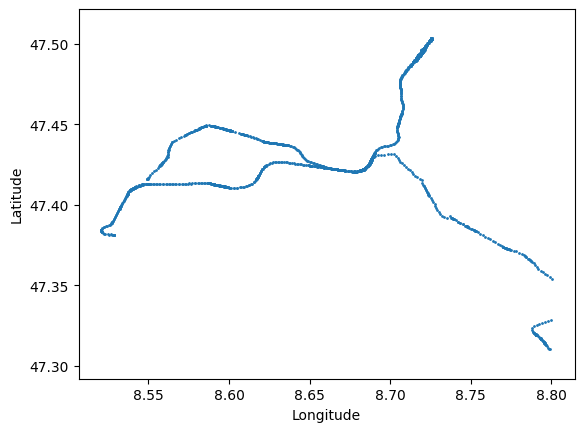

In [61]:
# 1 - Plot latitude and longitude of the nodes

plt.figure()
plt.scatter(graph.bins_df["lon"], graph.bins_df["lat"], s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.show()

In [62]:
# 2 - Folium plot of the graph

"""
The graph consists of data-points (every 1.5 meters) and of aggregated nodes (every 150 meters - or chosen otherwise).
We plot here :
* the data-points (every 1.5 meters) in the colour of the underlying "track gtg" (line), red for connections between different lines
* the aggregated nodes (every 150 meters) in the colour of the underlying "track gtg" (line), red for connections between different lines

The red connections are determined based on the "threshold_connection_m" parameter in the graph creation, its default value is 3 meters 
(the extremeties of all "track gtg" are connected to all data-points within 3 meters).

Use the flag plot_connections=False to not plot the connections between the aggregated nodes (in red).
"""

# plotting the data-points, not the aggregated nodes: one colour per underlying "track gtg" (line), red for connections between different lines
# graph.plot_folium_map()

# showing connections:   one colour per underlying "track gtg" (line), red for connections between different lines
# graph.plot_folium_map_of_nodes()

'\nThe graph consists of data-points (every 1.5 meters) and of aggregated nodes (every 150 meters - or chosen otherwise).\nWe plot here :\n* the data-points (every 1.5 meters) in the colour of the underlying "track gtg" (line), red for connections between different lines\n* the aggregated nodes (every 150 meters) in the colour of the underlying "track gtg" (line), red for connections between different lines\n\nThe red connections are determined based on the "threshold_connection_m" parameter in the graph creation, its default value is 3 meters \n(the extremeties of all "track gtg" are connected to all data-points within 3 meters).\n\nUse the flag plot_connections=False to not plot the connections between the aggregated nodes (in red).\n'

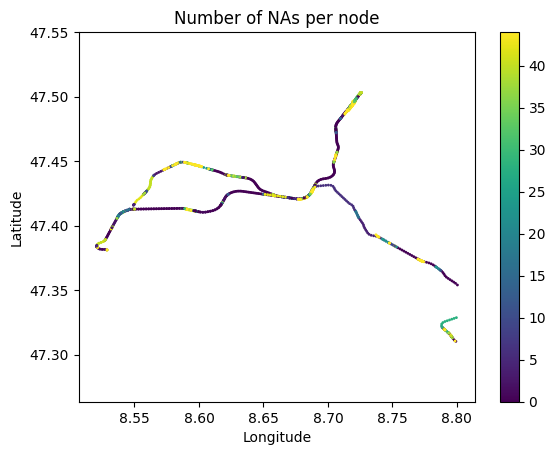

In [63]:
# 3 - Plot the number of NAs per node

indicators_of_interest = ["lonle_d1", "lonle_d2"]

count_NAs_per_node = graph.indicator_ts_dict[indicators_of_interest[0]].isna().sum(axis=1)
for indicator in indicators_of_interest[1:]:
    count_NAs_per_node += graph.indicator_ts_dict[indicator].isna().sum(axis=1)

plt.figure()
plt.scatter(graph.bins_df["lon"], graph.bins_df["lat"], c=count_NAs_per_node, s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.title("Number of NAs per node")
plt.axis("equal")
plt.show()

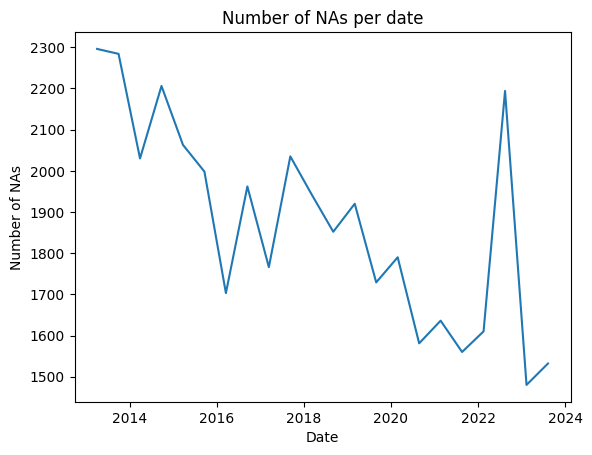

In [64]:
# 4 - Plot the number of NAs per date

count_NAs_per_date = graph.indicator_ts_dict[indicators_of_interest[0]].isna().sum(axis=0)
for indicator in indicators_of_interest[1:]:
    count_NAs_per_date += graph.indicator_ts_dict[indicator].isna().sum(axis=0)

plt.figure()
plt.plot(count_NAs_per_date)
plt.xlabel("Date")
plt.ylabel("Number of NAs")
plt.title("Number of NAs per date")
plt.show()

### Limit to nodes and dates of choice

We remove all nodes with any NAs for further inference. Therefore, to keep meaningful data, we do:
* Choose appropriate longitude and latitude ranges
* Choose date range automatically that maximizes the number of data items (#nodes without NAs x #dates)

Number of nodes:  40


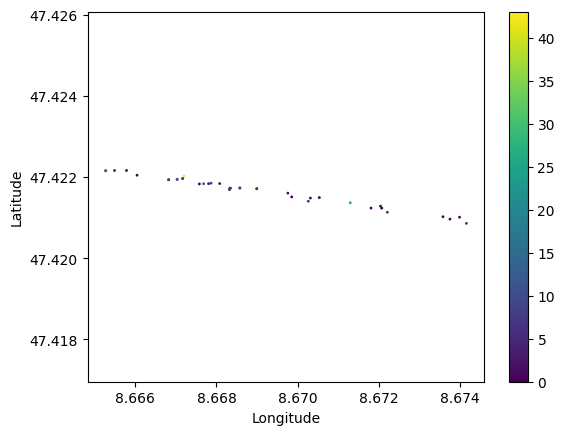

In [65]:
# 1 - Choose latitude and longitude of the nodes

lat1 = 47.41
lat2 = 47.444
lon1 = 8.665
lon2 = 8.675

filter_location = ((graph.bins_df["lat"] > lat1) & (graph.bins_df["lat"] < lat2) & (graph.bins_df["lon"] > lon1) & (graph.bins_df["lon"] < lon2)).values


print("Number of nodes: ", len(graph.bins_df[filter_location]))

plt.scatter(graph.bins_df[filter_location]["lon"], graph.bins_df[filter_location]["lat"], s=1, c=count_NAs_per_node[filter_location])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.colorbar()
plt.show()

In [66]:
# 2 - Choose date range automatically that maximizes the number of data items (#nodes without NAs x #dates)

"""
For the rest of the process, we will discard the nodes containing NAs in the chosen indicators.
Our goal is then to maximize the number of data items (#nodes without NAs x #dates) by choosing the best date range.
For this, we will loop through all possible date ranges and choose the one that maximizes the number of data items.
We will do this in two steps:
- first, we will loop through the dates in the forward direction
- second, we will loop through the dates in the backward direction
"""

scores_forward = []
best_score_forward = 0
best_t_forward = 0
n_nodes_no_na_forward = 0

max_timesteps = graph.indicator_ts_dict[indicators_of_interest[0]].shape[1]

# Loop through each time step to the end (forward direction)
for t in range(max_timesteps):

    timestep_left = max_timesteps - t

    # count NAs for each node
    count_NAs_per_node_t = graph.indicator_ts_dict[indicators_of_interest[0]].iloc[filter_location, t:].isna().sum(axis=1)
    for indicator in indicators_of_interest[1:]:
        count_NAs_per_node_t += graph.indicator_ts_dict[indicator].iloc[filter_location, t:].isna().sum(axis=1)
    
    n_nodes_no_NA_t = (count_NAs_per_node_t == 0).sum()

    score = n_nodes_no_NA_t * timestep_left
    scores_forward.append(score)
    if score > best_score_forward:
        best_score_forward = score
        best_t_forward = t
        n_nodes_no_na_forward = n_nodes_no_NA_t

# Initializing variables to find the best t in the backward direction
scores_backward = []
best_score_backward = 0
best_t_backward = 0
n_nodes_no_na_backward = 0

# Loop through each time step to the start (backward direction)
for t in range(max_timesteps, 0, -1):
    timestep_left = t

    # count NAs for each node
    count_NAs_per_node_t = graph.indicator_ts_dict[indicators_of_interest[0]].iloc[filter_location, :t].isna().sum(axis=1)
    for indicator in indicators_of_interest[1:]:
        count_NAs_per_node_t += graph.indicator_ts_dict[indicator].iloc[filter_location, :t].isna().sum(axis=1)

    n_nodes_no_NA_t = (count_NAs_per_node_t == 0).sum()

    score = n_nodes_no_NA_t * timestep_left
    scores_backward.append(score)
    if score > best_score_backward:
        best_score_backward = score
        best_t_backward = t
        n_nodes_no_na_backward = n_nodes_no_NA_t



print("Filtering NAs forward: t=", best_t_forward, ": ", n_nodes_no_na_forward, " nodes; ", best_score_forward, " data items")
print("Filtering NAs backward: t=", best_t_backward, ": ", n_nodes_no_na_backward, " nodes; ", best_score_backward, " data items")

if best_score_backward > best_score_forward:
    from_t = 0
    to_t = best_t_backward
    print("=> Backward na filter: from ", from_t, " to ", to_t,"; ", n_nodes_no_na_backward, " nodes")
else:
    from_t = best_t_forward
    to_t = max_timesteps
    print("=> Forward NA filter: from ", from_t, " to ", to_t,"; ", n_nodes_no_na_forward, " nodes")

count_NAs_per_node_final = graph.indicator_ts_dict[indicators_of_interest[0]].iloc[filter_location, from_t:to_t].isna().sum(axis=1)
for indicator in indicators_of_interest[1:]:
    count_NAs_per_node_final += graph.indicator_ts_dict[indicator].iloc[filter_location, from_t:to_t].isna().sum(axis=1)

nodes_no_NA_final = graph.bins_df[filter_location].index[count_NAs_per_node_final == 0].values

Filtering NAs forward: t= 4 :  18  nodes;  324  data items
Filtering NAs backward: t= 19 :  19  nodes;  361  data items
=> Backward na filter: from  0  to  19 ;  19  nodes


Number of nodes without NAs:  19


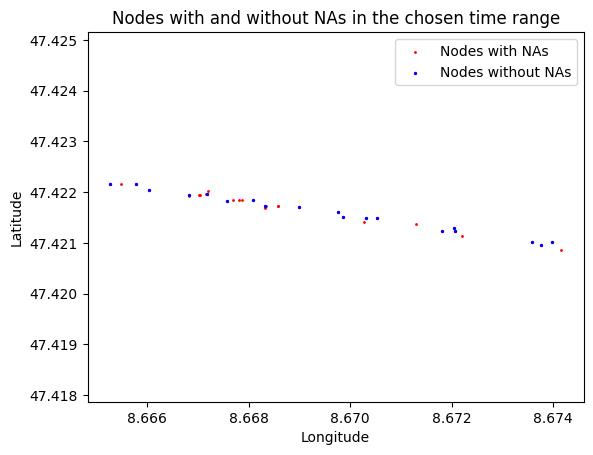

In [67]:
print("Number of nodes without NAs: ", len(nodes_no_NA_final))

plt.figure()
plt.scatter(graph.bins_df[filter_location]["lon"], graph.bins_df[filter_location]["lat"], s=1, c="red", label="Nodes with NAs")
plt.scatter(graph.bins_df.loc[nodes_no_NA_final]["lon"], graph.bins_df.loc[nodes_no_NA_final]["lat"], s=2, c="blue", label="Nodes without NAs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.title("Nodes with and without NAs in the chosen time range")
plt.legend()
plt.show()

In [68]:
# 3 - Filter the graph object to keep the chosen time range and location range

""" 
Note that the final set of nodes only depend on the location range.
With these nodes, we will use the ones without NAs in the chosen time range during the analysis,
but we must keep the nodes with NAs in the graph object to represent the connections between the nodes.
"""

graph.select_subgraph_nodes(lat1=lat1, lat2=lat2, lon1=lon1, lon2=lon2, t_from=from_t, t_to=to_t)

### Adjust the dataset

In [69]:
# 1 - Adjust the actions

"""
Sometimes, the effect of one action seems to be delayed in the dataset, this might be due to data discrepancies or other reasons.

Here, for each action (tamping, renewal, re-tamping), we observe if moving the action by one time step improves the data quality.
If the data quality improves, we move the action by one time step.
"""

temp = graph.adjust_actions_ts("lonle_d1", "lonle_d2", COEF_before=4, COEF_var=8)
print("Number of actions adjusted: ", temp)

Number of actions adjusted:  2


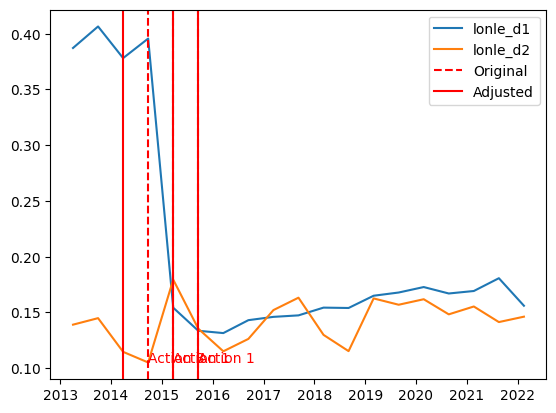

In [70]:
# 2 - Plot comparison of the adjusted action vs the original action

original = graph.actions_ts
adjusted = graph.actions_ts_adjusted

# find node with not equal adjusted and original action
nodes_not_equal = []
for node in original.index:
    if not np.array_equal(original.iloc[node,:], adjusted.iloc[node,:]):
        nodes_not_equal.append(node)

node_to_plot = np.random.choice(nodes_not_equal)

plt.figure()

plt.plot(graph.indicator_ts_dict["lonle_d1"].iloc[node_to_plot], label="lonle_d1")
plt.plot(graph.indicator_ts_dict["lonle_d2"].iloc[node_to_plot], label="lonle_d2")

min_y = min(graph.indicator_ts_dict["lonle_d1"].iloc[node_to_plot].min(), graph.indicator_ts_dict["lonle_d2"].iloc[node_to_plot].min())

# vertical lines for the actions
c = 0
for t, act in enumerate(graph.actions_ts.iloc[node_to_plot].values):
    if act != 0:
        if c == 0:
            plt.axvline(x=graph.indicator_ts_dict["lonle_d1"].columns[t], color="red", linestyle="--", label="Original")
            plt.text(graph.indicator_ts_dict["lonle_d1"].columns[t], min_y, f"Action {act}", rotation=0, color="red")
            c += 1
        else:
            plt.axvline(x=graph.indicator_ts_dict["lonle_d1"].columns[t], color="red", linestyle="--")            
            plt.text(graph.indicator_ts_dict["lonle_d1"].columns[t], min_y, f"Action {act}", rotation=0, color="red")


c = 0
for t, act in enumerate(graph.actions_ts_adjusted.iloc[node_to_plot].values):
    if act != 0:
        if c == 0:
            plt.axvline(x=graph.indicator_ts_dict["lonle_d1"].columns[t], color="red", label="Adjusted")
            c += 1
        else:
            plt.axvline(x=graph.indicator_ts_dict["lonle_d1"].columns[t], color="red")

plt.legend()
plt.show()

Count = 543, Action 0: Mean = 0.0005633886713353951, Median = 0.004121083469385556, 25th Percentile = -0.028153216293007266, 75th Percentile = 0.0315987031435713
Count = 24, Action 1: Mean = -0.02036485908147286, Median = -0.002766194817512488, 25th Percentile = -0.035566448269662786, 75th Percentile = 0.04577314854501958
Count = 16, Action 2: Mean = -0.07623222149880109, Median = -0.01960752686407234, 25th Percentile = -0.07715262021272504, 75th Percentile = -0.003882168047413037
Count = 19, Action 3: Mean = -0.024878125193466924, Median = -0.016705136414822574, 25th Percentile = -0.07349472560583886, 75th Percentile = 0.026310672193201573


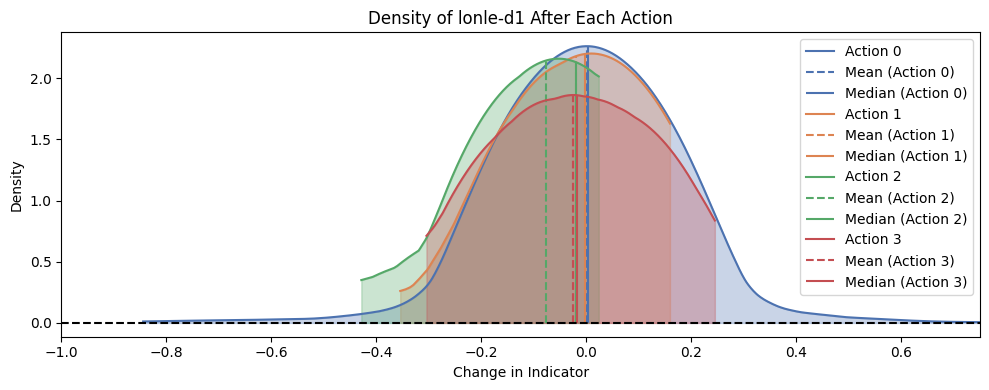

In [71]:
# 3 - Plot average effect of actions

"""
Actions are ordered like this:
* 0 - Do nothing
* 1 - Re-tamping
* 2 - Tamping
* 3 - Renewal

!This order differs form the one of the report!

This can be adjusted in the function create_dict_act in the data_graph_utils.py file.

The plot below displays the distribution of the following change in the indicator after each action.
"""

# BEFORE ADJUSTMENT OF THE ACTIONS
analyze_action_effects(graph.actions_ts.values, graph.indicator_ts_dict["lonle_d1"].values, "lonle-d1", xlim1=-1, xlim2=0.75)

Count = 543, Action 0: Mean = 0.00023643615481399596, Median = 0.004121083469385556, 25th Percentile = -0.028153216293007266, 75th Percentile = 0.0315987031435713
Count = 24, Action 1: Mean = -0.02036485908147286, Median = -0.002766194817512488, 25th Percentile = -0.035566448269662786, 75th Percentile = 0.04577314854501958
Count = 16, Action 2: Mean = -0.07623222149880109, Median = -0.01960752686407234, 25th Percentile = -0.07715262021272504, 75th Percentile = -0.003882168047413037
Count = 19, Action 3: Mean = -0.015534166431829038, Median = -0.016705136414822574, 25th Percentile = -0.056574283457273764, 75th Percentile = 0.022078284466225492


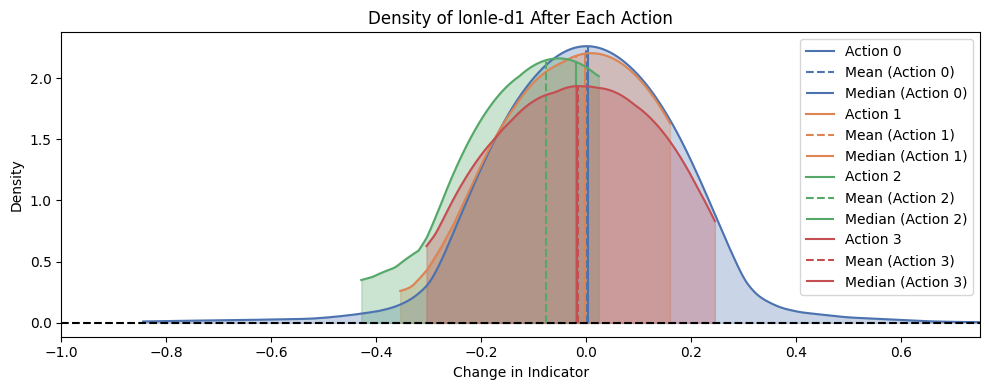

In [72]:
# AFTER ADJUSTMENT OF THE ACTIONS
analyze_action_effects(graph.actions_ts_adjusted.values, graph.indicator_ts_dict["lonle_d1"].values, "lonle-d1", xlim1=-1, xlim2=0.75)

### Save adjusted graph

In [73]:
# fix issue with Adj matrix not being symmetric

adj_matrix = graph.adj_matrix
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
graph.adj_matrix = adj_matrix

In [74]:
# is the graph connected?

G = nx.from_numpy_array(graph.adj_matrix.values)
print("Is the graph connected? ", nx.is_connected(G))

Is the graph connected?  True


In [75]:
# 1 - Save as pickle

path_graph_adjusted = path_graph.replace(".pkl", "_small_adj.pkl")
with open(path_graph_adjusted, "wb") as f:
    pickle.dump(graph, f)

In [84]:
# 2 - Save as json

path_graph_adjusted_json = path_graph.replace(".pkl", "_small_adj")
graph.save_graph_json(path_graph_adjusted_json)